<a href="https://colab.research.google.com/github/ML-HW-SYS/a2/blob/main/5_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Quantization** (50 pts)


This module utilizes the trained model from the previous section to perform quantization so as to improve the execution efficiency of the model. There are two main quantization techniques here:

1. Post Training Quantization (PTQ)

2. Quantization Aware Training (QAT)

# 1.1 Understanding Audio Processing

The DNN in the first part of this lab (1_quantization.pynb) works on audio data. The main task of the DNN is to detect and classify sound waves using audio files. The dataset we will be using contains multiple audio recordings and the DNN classifies them into 4 categories: Loud Yes, Loud No, Quiet Yes, Quiet No.

For any deep learning model exercise, it is best to first understand the input data modality. In our case, its audio files (.wav). Audio files can be directly processed as time series data, or converted into frequency domain and processed as images. Below are some visualizations for the audio data from the dataset we will be using. These visualizations are only meant to understand the data. 

The dataset is already provided to you. You don't need to download it.

## Time domain visualization

This part of the notebook represents the .wav audio samples as signals plotted on a graph. The x-axis of the graphs represents time and is derived using frame rate. The graphs depict the magnitudes of the sound of the audio samples.

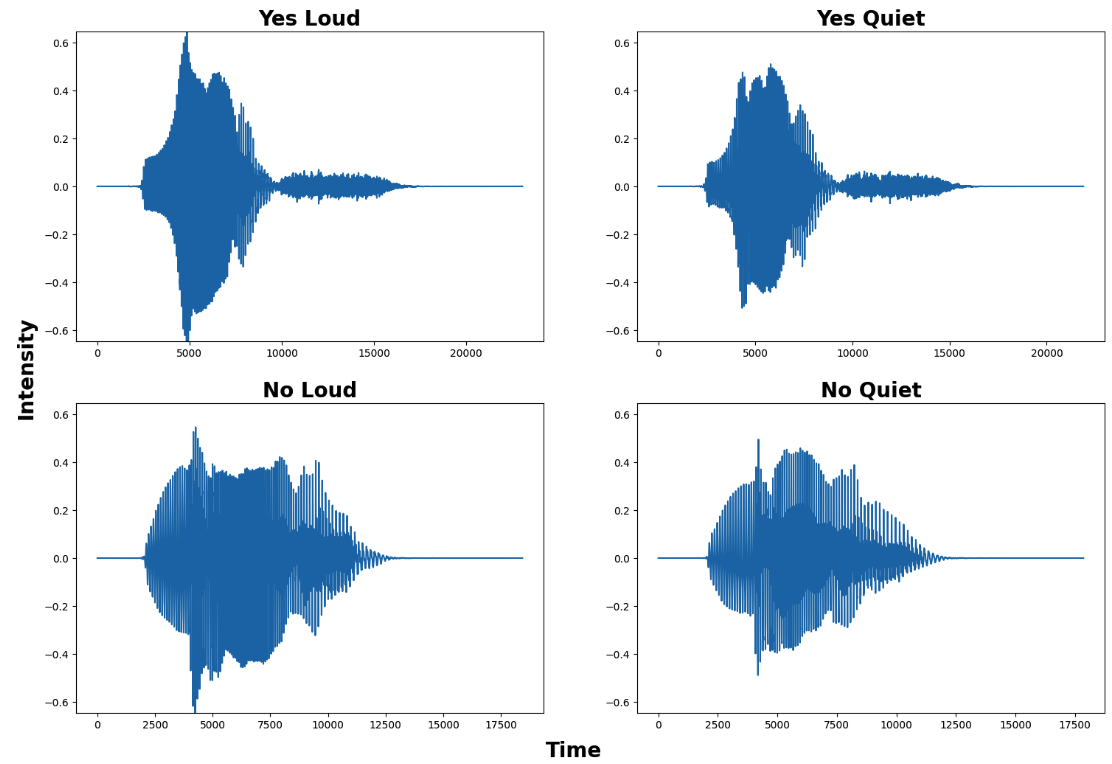

## Frequency domain visualization 

Here, the audio samples are displayed in the frequency domain through Fourier transformations. The x axis, instead of representing time, now represents frequency, and the y axis represents the amount of decibels in the sample at each frequency.

Adapted from: https://makersportal.com/blog/2018/9/13/audio-processing-in-python-part-i-sampling-and-the-fast-fourier-transform

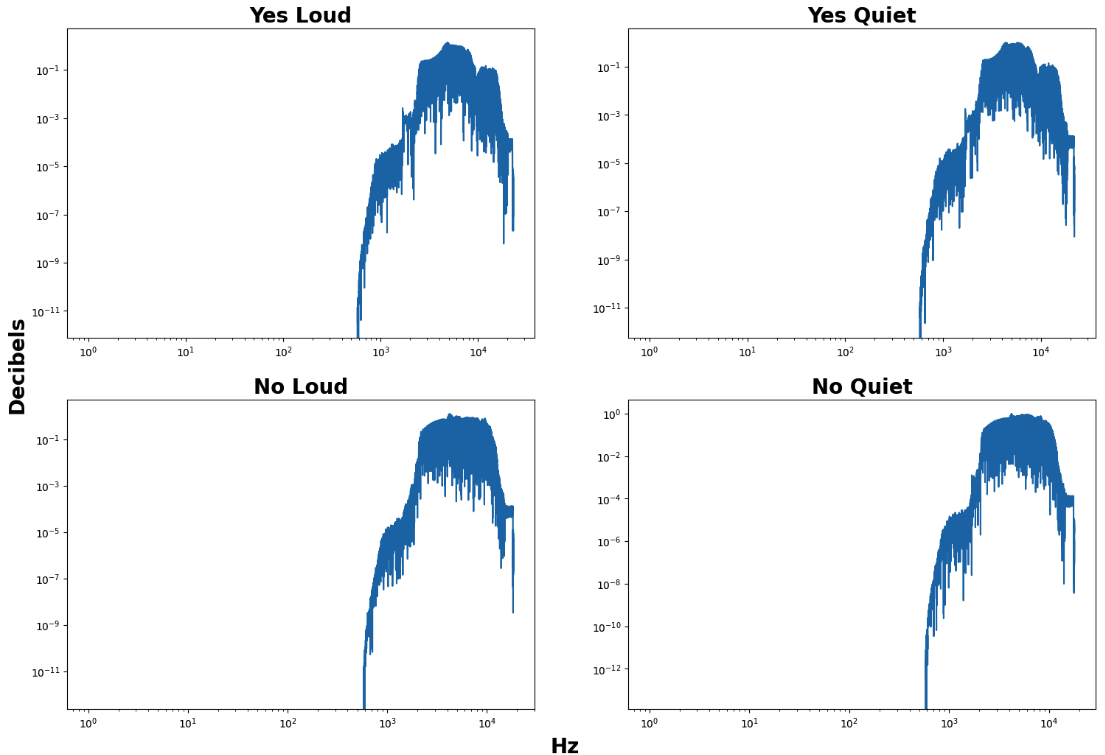

## Spectogram

A spectogram is a figure which visually represents the spectrum of frequencies of a recorded audio over time. This part of the notebook produces those "pictures" of your audio samples. Brighter color indicates more concentration around specific frequencies. They are important in machine learning since they capture the shape and structure of audio in a format algorithms can manipulate.

For more information on spectrograms use in ML, checkout: [Learning from Audio: Spectrograms](https://towardsdatascience.com/learning-from-audio-spectrograms-37df29dba98c)

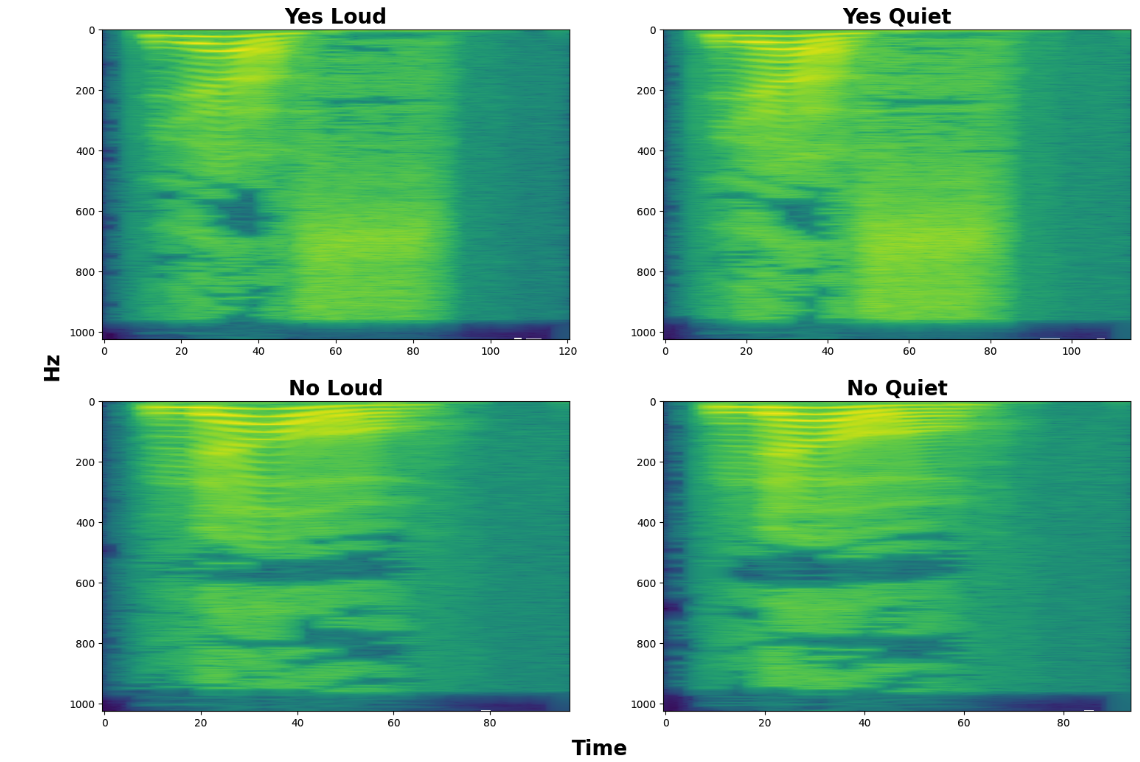

## Mel Spectogram 

Mel spectrograms are different from spectrograms in that they display frequencies on the mel scale, which is nonlinear. The purpose of this logarithmic transformation is to account for the fact that humans do not perceive frequencies on a linear scale. Therefore, using the mel scale can help us-- and ML algorithms-- better associate the features to human hearing.

Adapted from: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0

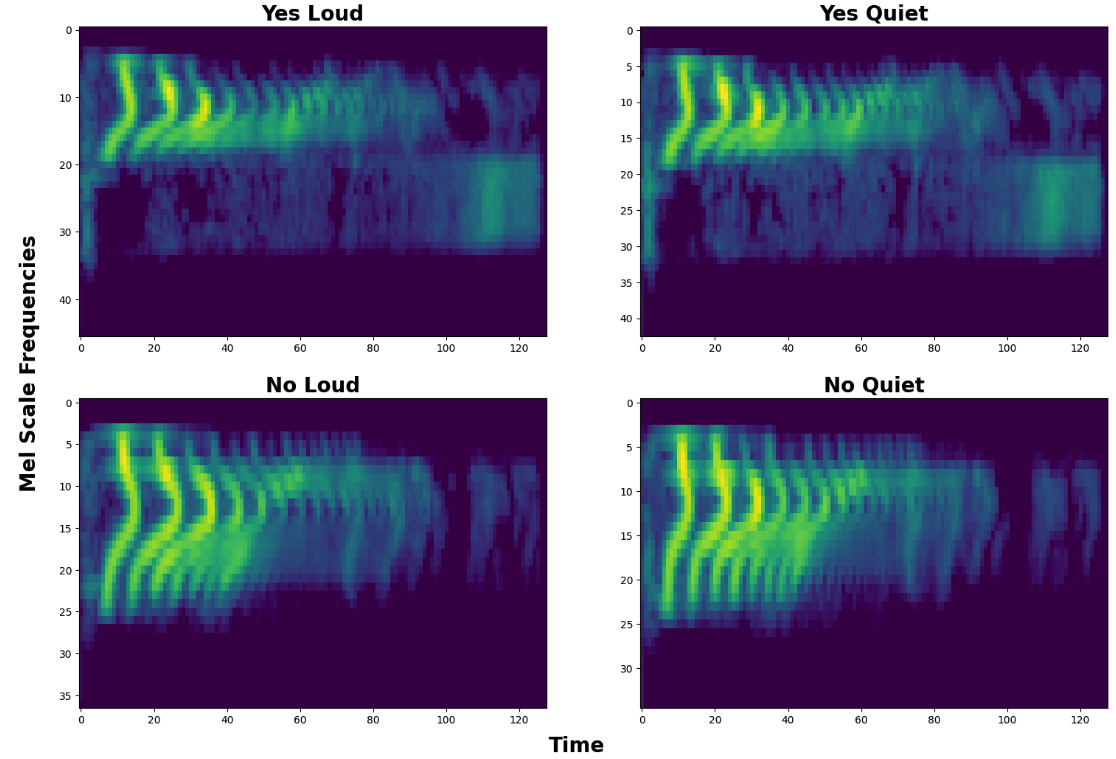


### Mel frequency cepstral coefficients (MFCC) spectrogram

Similar to spectrograms, MFCC is another way to visualize sound. It bands together frequencies according to the mel scale. 

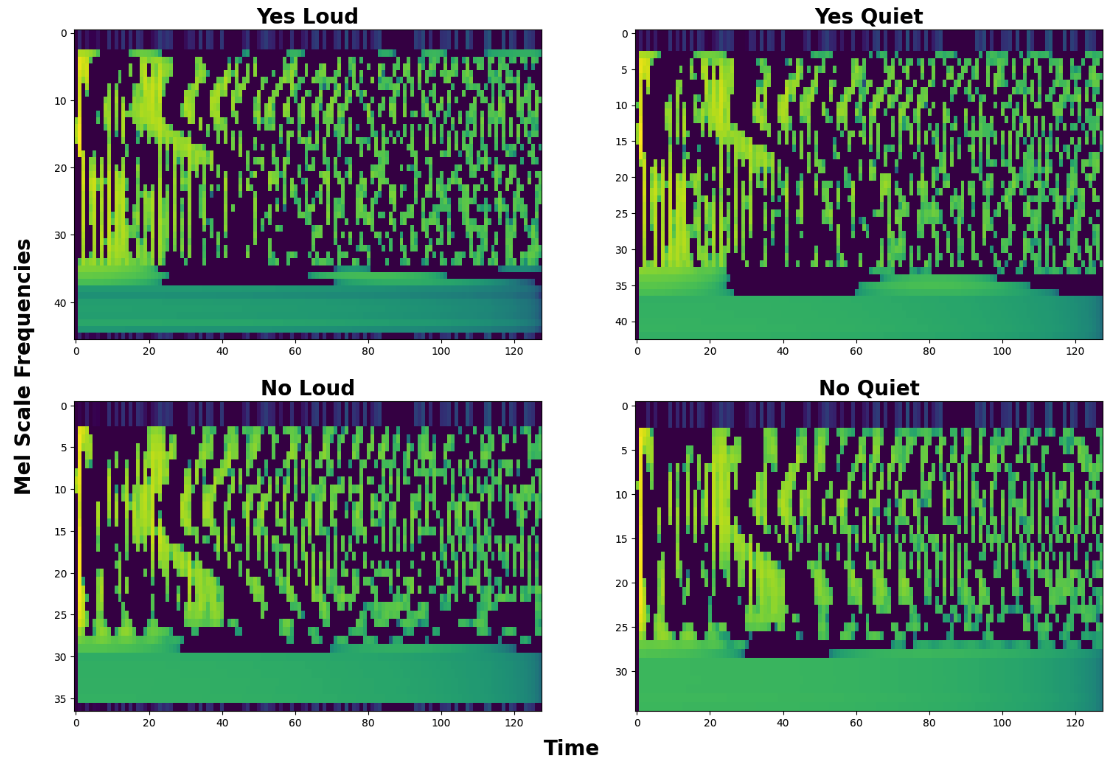


If you would like to learn more about Mel Spectrograms and MFCC, check out these links (as a starting point): 
* [Learning from Audio: The Mel Scale, Mel Spectrograms, and Mel Frequency Cepstral Coefficients](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8). 
* [Some Commonly Used Speech Feature Extraction Algorithms](https://www.intechopen.com/chapters/63970)

## 1.2 Understand the DNN Model

In this part of the assignment, we will be using a very small CNN for audio processing. The model is called TinyConv. 

Go to `src/networks.py` for the description of the model. Our TinyConv model currently consists of 7 layers:


1. [Reshape](https://pytorch.org/docs/stable/generated/torch.reshape.html)
2. [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)
3. [Relu](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) 
4. [Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) 
5. Reshape
6. [Fully Connected (Linear)](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
7. [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax)

We will provide a pre-trained model to you. This model will use fp32 weights and activations. You don't need to train this fp32 model. You will be quantizing this model to int4. That means a 8x reduction in overall model size. You will observe the reduction in accuracy that happens with this quantization. QAT can recover some/much of this accuracy.

## 1.3 Setup

### Install required packages

In [ ]:
# Install libraries
!pip install tqdm
!pip install torchaudio

### Import code dependencies

In [ ]:
# Import libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import copy
import os

import sys
##### TODO TODO TODO 
# Please update the Project Location based on your directory
PROJECT_ROOT = "/home/kmhatre/TA_CEN598/lab_4/Machine_Learning_Acceleration_Lab4"
# Adding assignment 2 to the system path
# -- make sure this matches your lab code's root directory
sys.path.insert(0, PROJECT_ROOT)

# Import data_proc to use data processing functions
import src.data_proc as data_proc

# Import constants to use constants defined for training
from src.constants import *

# Set random seed
# Make sure the shuffling and picking is deterministic
# Note that different value of random_seed may change rate of variation in loss/accuracy during training
# Using the same random seed value every time you rerun the notebook will 
# reproduce the training and testing results  
random_seed = RANDOM_SEED
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

## 1.4 Define Quantization Functions



#### TODO 1: Implement the `uniform_quantize` function in `src/quant.py` (6 pts)


In [ ]:
from src.quant import uniform_quantize

# Mini test case for uniform_quantize
with torch.no_grad():
    x = torch.tensor([2, -0.5, 0., 1.])
    scale = 1
    zero = 0
    y = uniform_quantize(x, scale, zero)
    print(y)

#### TODO 2: Implement the `SymmetricQuantFunction` forward function in `src/quant.py`  (6 pts)


In [ ]:
from src.quant import SymmetricQuantFunction

quant_f = SymmetricQuantFunction.apply

x = torch.tensor([2, -0.5, 0., 1.])
x.requires_grad = True
bw = 2
y = quant_f(x, bw, scale, zero)
(y ** 2).sum().backward()

print(y)
print(x.grad)

#### TODO 3: Implement the `AsymmetricQuantFunction` forward function in `src/quant.py`  (6 pts)

In [ ]:
from src.quant import AsymmetricQuantFunction

quant_f = AsymmetricQuantFunction.apply

x = torch.tensor([2, -0.5, 0., 1.])
x.requires_grad = True
bw = 2
y = quant_f(x, bw, scale, zero)
(y ** 2).sum().backward()

print(y)
print(x.grad)

#### TODO 4: Finish the implementation of `get_quantization_params` function in `src/quant.py` (3 pts)

In [ ]:
from src.quant import QConfig

qconfig = QConfig(quant_bits=4, is_symmetric=True)
print(qconfig.get_quantization_params(x.min(), x.max()))

qconfig = QConfig(quant_bits=4, is_symmetric=False)
print(qconfig.get_quantization_params(x.min(), x.max()))

#### TODO 5: Implement the `quantize_weights_bias` function in `src/quant.py` (6 pts)

In [ ]:
from src.quant import quantize_weights_bias, QConfig

qconfig = QConfig(quant_bits=4, is_symmetric=True)

w1 = nn.Parameter(torch.tensor([2, -0.5, 0., 1.]))
qw1 = quantize_weights_bias(w1, qconfig)
print(qw1.data)

w2 = nn.Parameter(torch.tensor([2.5, -1, 0., 1.5]))
qw2 = quantize_weights_bias(w2, qconfig)
print(qw2.data)

#### TODO 6: Finish the implementation of `conv2d_uniform_quantized` function in `src/quant.py`  (6 pts)

In [ ]:
import torch.nn as nn
from src.quant import QuantWrapper

layer = nn.Linear(2, 2)
layer.weight.data = torch.tensor([[0.1, 0.1], [-0.1, 0.1]]).view(2, 2).float()
layer.bias.data = torch.tensor([1, 2]).view(*layer.bias.shape).float()
x = torch.tensor([[0., 1]])
print(layer(x))

quant_layer = QuantWrapper(
    layer, 
    QConfig(quant_bits=4, is_symmetric=True), 
    QConfig(quant_bits=4, is_symmetric=True), 
    QConfig(quant_bits=4, is_symmetric=True))
print(quant_layer(x))


## 1.5 Prepare model for QAT (Quantization Aware Training)

### Get Audio Processor, Devices, Data Loader, and Model

In [ ]:
# Copy the dataset from "/scratch/kmhatre/CEN524/speech_commands_dataset/speech_commands_v0.02.tar.gz" 
# to your home location and extract it using the commands below. The extraction takes a significant amount of time. 
! cp -r /scratch/kmhatre/CEN524/speech_commands_dataset/speech_commands_v0.02.tar.gz .
! mkdir -p ./speech_commands
! tar -xvf speech_commands_v0.02.tar.gz -C ./speech_commands

In [ ]:
# Create audio_processor
# TODO: Replace the below line with the location specified in the above command.
Audio_dataset = "/home/kmhatre/TA_CEN598/lab_4/speech_commands_dataset"
audio_processor = data_proc.AudioProcessor(data_dir=Audio_dataset)
print("Audio_processor created")

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} to run the training scrpit.')

# Define data loaders
from src.loaders import make_data_loaders
data_loaders = make_data_loaders(audio_processor, device)
train_loader = data_loaders['training']
test_loader = data_loaders['testing']
valid_loader = data_loaders['validation']

# Create a full precision (float32) TinyConv model
from src.networks import TinyConv
model_fp32 = TinyConv(model_settings=audio_processor.model_settings, \
    n_input=1, n_output=audio_processor.num_labels)

model_fp32

# Calculate the number of weights/parameters in this model
num_params = sum(p.numel() for p in model_fp32.parameters() if p.requires_grad)
print("Total number of trainable parameters: ", num_params / float(1e6), "M")

### Load Pretrained Model for Quantization Aware Finetuning

In this notebook, we will load the trained 32-bits float model to finetune it in a quantization-aware way. 



In [ ]:
!ls {TORCH_DIR}

### TODO 7: Replace the torch_path model with the trained model path.

You can find the name of your file in `TORCH_DIR` under the folder icon to the left. (Or from running the tab above).

In [ ]:
# TODO: Replace me!
torch_path = os.path.join(TORCH_DIR, "tinyconv_float32_init_seed0_89.47%_0.pt")

# Load model
model_fp32.load_state_dict(torch.load(torch_path))
model_fp32

### Define settings for weight and activation quantization 

In [ ]:
# We choose 4 bit quantization as an example because accuracy improvements will 
# be more obvious with 4-bit or lower bit quantization
QUANT_BITS = 4
# Settings for activations quantization: n-bit asymmetric quantization
a_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=False)
# Settings for weights quantization: n-bit symmetric quantization
w_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)
# Settings for bias quantization: n-bit symmetric quantization
b_qconfig = QConfig(quant_bits=QUANT_BITS, is_symmetric=True)

### Prepare quantization aware training model

In [ ]:
from src.quant import quantize_model
qat_model_nbit = quantize_model(
    model_fp32, a_qconfig=a_qconfig, w_qconfig=w_qconfig, b_qconfig=b_qconfig)

# Print to see the model prepared for QAT
print(qat_model_nbit)

##  1.6 Perform Quantization Aware Training (5 pts)

In this training, we will finetune the 32-bits float pretrained model. The goal is to finetune the weights of the 32-bits float model such that the resulted model will have better accuracy after quantization.

In [ ]:
import time
from src.train_val_test_utils import train, test
from src.train_val_test_utils import create_optimizer


def run_training(model, data_loaders, n_epoch, log_interval, optimizer, scheduler=None, 
                 save_interval=1, resume=True, checkpoint_path=None, verbose=False):
    test_loader = data_loaders['testing']
    with tqdm(total=n_epoch) as pbar:
        completed_epoch = 1
        if resume:
            try:
                #continue training with previous model if one exists
                if checkpoint_path is None:
                    raise ValueError
                checkpoint = torch.load(checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                if scheduler is not None:
                    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                completed_epoch = checkpoint["epoch"] + 1
                model.eval()
                pbar.update(completed_epoch)
            except:
                pass

        for epoch in range(completed_epoch, n_epoch + 1):
            train_iters = len(data_loaders['training'])
            train(model, data_loaders, optimizer, epoch, device, verbose)
            test(test_loader, model, device, 
                 epoch=None, loader_type='Test')
            
            if scheduler is not None:
                scheduler.step()
            #checkpoint the model every run
            if epoch % save_interval == 0 and checkpoint_path is not None:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None
                }, checkpoint_path)
                
            # Update epoch pbar
            pbar.update(1)


verbose = False
log_interval = 100
num_batches = len(train_loader)
n_epoch = 30
print(f'#batches: {num_batches} \n#epochs: {n_epoch} \n#total training steps: {num_batches * n_epoch}')

# Create optimizer
optimizer_quant = create_optimizer(model=qat_model_nbit, learning_rate=0.001)
print(optimizer_quant.state_dict())

checkpoint_path = os.path.join(TORCH_DIR, "quant_checkpoint.pt")
qat_model_nbit.to(device)
run_training(
    model=qat_model_nbit, data_loaders=data_loaders, 
    n_epoch=n_epoch, log_interval=log_interval, 
    optimizer=optimizer_quant, scheduler=None, 
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

For fair comparison, we conduct the same funetuning for the float model.

In [ ]:
# Create optimizer
optimizer_fp32 = create_optimizer(model=model_fp32, learning_rate=0.0001)

checkpoint_path = os.path.join(TORCH_DIR, "fp32_finetune_checkpoint.pt")
model_fp32.to(device)
run_training(
    model=model_fp32, data_loaders=data_loaders, 
    n_epoch=n_epoch, log_interval=log_interval, 
    optimizer=optimizer_fp32, scheduler=None, 
    resume=False,
    checkpoint_path=checkpoint_path,
    verbose=verbose
)

## 1.7 Testing

We will compute the accuracy of the finetuned model in train/val/test set in this section.
Note that this is not the final accuracy we want the model to perform well on. 
We would like our quantized-aware-finetuned model to perform well when quantized into integer. 
But the training/validation/testing accuracy of these model in quantization simulation model is still worth looking at for sanity checking purpose.

In [ ]:
from src.train_val_test_utils import plot_acc

test_time_data_loaders = make_data_loaders(
    audio_processor, device, 
    test_batch_size=1, valid_batch_size=1,
    num_workers=0
)

plot_acc(
    test_time_data_loaders['training'], qat_model_nbit, audio_processor, device,
    "Training", 'n-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], qat_model_nbit, audio_processor, device,
    "Validation", 'n-bit Quantized TinyConv', "float")
plot_acc(
    test_time_data_loaders['testing'], qat_model_nbit, audio_processor, device,
    'Testing', 'n-bit Quantized TinyConv', "float")

In [ ]:
plot_acc(
    test_time_data_loaders['training'], model_fp32, audio_processor, device,
    "Training", 'FP32 FT TinyConv', "float")
plot_acc(
    test_time_data_loaders['validation'], model_fp32, audio_processor, device,
    "Validation", 'FP32 FT TinyConv', "float")
acc = plot_acc(
    test_time_data_loaders['testing'], model_fp32, audio_processor, device,
    'Testing', 'FP32 FT TinyConv', "float")

## 1.8 Saving the Trained Model

In [ ]:
from src.train_val_test_utils import choose_name
from src.quant import dequantize_model

# Save the qat model
qat_model_nbit_float = dequantize_model(qat_model_nbit)
file_name = choose_name("quant")
# You can also define your own path
qat_torch_path = os.path.join(TORCH_DIR, f'(QAT{QUANT_BITS}bit){file_name}.pt')
# Save the trained n-bit qat pytorch model to PATH
torch.save(qat_model_nbit.state_dict(), qat_torch_path)
qat_torch_path

## 1.9 Understanding and Evaluate the Effectiveness of Quantization-Aware Training (QAT) (5 pts)

### Model conversion: Quantized/Float Fine-tuning Model Converted to Integer Models

In [ ]:
from src.quant import dequantize_model
from src.quant_conversion import convert_to_int

In [ ]:
# Convert to quantized model
# Here, we convert the model to int16 rather then int4 or int8. We do this because the layer outputs are not quantized to int4 or int8. 
# Thus, completely making the model int8/int4 will require more modifications to the quantization process.

# Quantized integer model of qat_model_nbit (quantized aware finetuning model)
int_model_nbit = convert_to_int(
    qat_model_nbit, QUANT_BITS, dtype=torch.int16) 
    
# Post quantized model of model_fp32 (full-precision finetuned model)
post_quant_model = convert_to_int(
    model_fp32, QUANT_BITS, dtype=torch.int16) 
  
# Floating point models of the qat_model_nbit, without QuantWrappers
float_model_nbit = dequantize_model(qat_model_nbit)
print("============")
print(int_model_nbit)

In [ ]:
from src.quant_conversion import print_features

# Select a sample data to see the features of it
sample_data, _ = audio_processor.get_data_from_file(
    audio_processor.data_index['testing'][0], BACKGROUND_FREQUENCY,
    BACKGROUND_VOLUME_RANGE, TIME_SHIFT_SAMPLE, 'testing')

print("=" * 80)
print("Features from Quantized QAT Model")
print("-" * 80)
print_features(sample_data, int_model_nbit, 'Quantized QAT Model')
print()
print("=" * 80)
print("Features from Model fp32")
print("-" * 80)
print_features(sample_data, model_fp32, "Model fp32")

### Compare the Performance Between Integer Models from Float/Quantized-Aware Finetuning (7 pts)

In [ ]:
from src.quant_conversion import compare_model, compare_model_mse

# Compare differences in predictions
# QAT trained floating point model vs. integer model converted from the QAT model 
# Percentage of same predictions shows how "quantization aware" the float point model is 
_ = compare_model(test_loader, float_model_nbit, int_model_nbit)
_ = compare_model_mse(test_loader, float_model_nbit, int_model_nbit)

In [ ]:
from src.quant_conversion import compare_model, compare_model_mse

# Float32 model vs. integer model converted from the float32 model using post training quantization
_ = compare_model(test_loader, model_fp32, post_quant_model)
_ = compare_model_mse(test_loader, model_fp32, post_quant_model)

### <center>This marks the end of part 1 the lab</center>